## Training and Compiling GluonCV Mask Detector


1. [Introduction](#Introduction)
2. [Dataset](#Dataset)
3. [Download dataset](#Download-dataset)
4. [Train model](#Train-model)
5. [Predictions by trained model](#Predictions-by-trained-model-on-notebook-instance(optional))
6. [Compile model](#Compile-model)


## Introduction

This sample notebook provides a step-by-step guide for training and compiling a mask detection model using SageMaker and GluonCV. ML model training begins with labeling data, followed by training, and finally, compilation and deployment on the edge device. Mask detection is performed by finetuning an SSD Mobilenet trained on the Pascal VOC dataset. This mask detection model uses SageMaker Ground Truth for data labeling, MXNet with GluonCV for training object detection model, and SageMaker Neo for edge device based compilation. The edge device is Jetson Nano.

__Optional__

Here are the links for different frameworks and functionalities used in this neo compilation sample notebook. For basic familiarity with the modules visit the following links.

* Amazon S3 - [Amazon S3](https://aws.amazon.com/s3)
* Data labeling - [Amazon SageMaker Ground Truth](https://docs.aws.amazon.com/sagemaker/latest/dg/sms.html)
* Train model in Amazon SageMaker - [Train model in Amazon SageMaker](https://docs.aws.amazon.com/sagemaker/latest/dg/how-it-works-training.html)
* Compilation of model - [SageMaker Neo Compilation](https://docs.aws.amazon.com/sagemaker/latest/dg/neo.html)
* MXNet - [MXNet](https://mxnet.apache.org/)
* GluonCV - [GluonCV Toolkit](https://gluon-cv.mxnet.io/)

### Kernel for the notebook

This notebook requires conda_mxnet_p36 kernel. So set the kernel of the notebook. You can select the kernel from the top right corner.

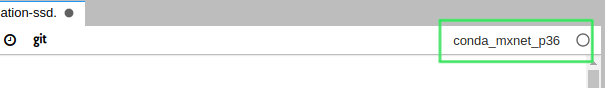

### Requirements
* S3 bucket
* Notebook instance with access to S3 bucket _solkit-images_

## Dataset

The dataset contains two classes.
* mask
* no_mask

[Google_advanced_image_search](https://www.google.com/advanced_image_search), [Kaggle_datasets](https://www.kaggle.com/) ..etc are some of the data resources for face-masks dataset. 

The dataset and labeling for this example are provided. In this training session, we have used approximately 800+ images from each class.
The dataset includes data from [Kaggle - Facemask Detection](https://www.kaggle.com/andrewmvd/face-mask-detection) with a [CC0 license](https://creativecommons.org/publicdomain/zero/1.0/).

The preparation of the dataset begins with collecting adequate data for the ML model, then labeling the data. In this training, the dataset was labeled using AWS Sagemaker Ground Truth. The output is a ___'.manifest'___ file with bounding boxes and classes of the objects in the image.

One can also verify the current labels using SageMaker Ground Truth.

We can perform labeling using the Amazon work team or our own private team or third party vendors to label the data.

Labeling 350 images using a private team in SageMaker Ground Truth costs $28.

__Labeling examples__

* Class -mask

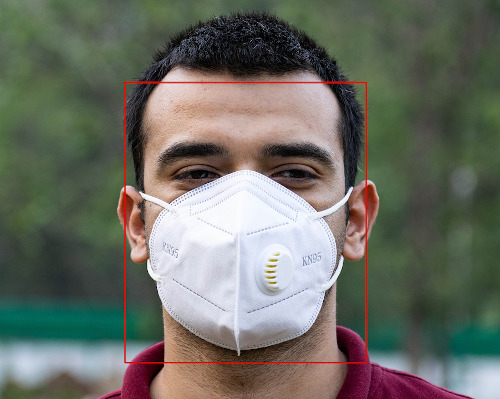

* Class - no_mask

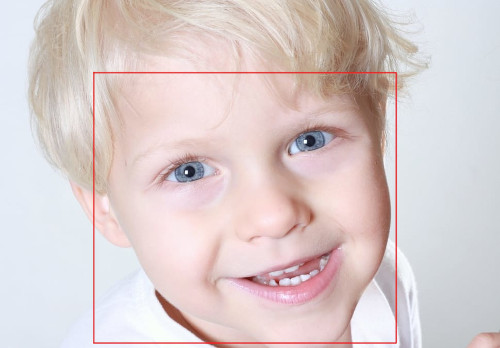


### Import python modules

Import the necessary python modules to run the code. For the object detection model, we need MXNet and GluonCV. SageMaker python module for sagemaker functionalities, json for manifest file operations, and matplotlib for plotting images. Install the GluonCV module for object detection. Since the notebook kernel in conda_mxnet_p36, mxnet module is available. GluonCV has to be installed. We can install it using pip command. Terminal commands can be executed in a code cell by adding an exclamation mark in front of the command. An example of a change directory command.

Eg. !cd directory/


In [1]:
!pip3 install gluoncv

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/mxnet_p36/bin/python -m pip install --upgrade pip' command.


In [3]:
import sagemaker
import mxnet as mx
import matplotlib.pyplot as plt
from sagemaker.mxnet import MXNet
from gluoncv import model_zoo, data, utils
import gluoncv as gcv
import numpy as np
import json
import os
import random
import boto3
import threading

### Get the region of notebook instance and S3 bucket.

The notebook instance and S3 bucket should be in the same region. Notebook instance can access only the S3 bucket in the same region. If the region is the same for both the instance and bucket, we can proceed with the training, else it results in an error.

Here in the following code, enter your bucket name instead of ___< my bucket name >__.

In [4]:
bucket = '<my bucket name>'

region = boto3.session.Session().region_name
s3 = boto3.client('s3')
bucket_region = s3.head_bucket(Bucket=bucket)['ResponseMetadata']['HTTPHeaders']['x-amz-bucket-region']
assert bucket_region == region, "Your S3 bucket {} and this notebook should be in the same region.".format(bucket)

### SageMaker execution role and Session

IAM role for the notebook instance. We can obtain the role using the function __get_execution_role()__. We pass this role as an argument for the training job.

Session manages the interaction between SageMaker functionalities and other AWS services. [SageMaker Session](https://sagemaker.readthedocs.io/en/stable/api/utility/session.html#)

In [5]:
role = sagemaker.get_execution_role()
sagemaker_session = sagemaker.Session(default_bucket = bucket)
bucket = sagemaker_session.default_bucket()
print('Default bucket = {}'.format(bucket))

Default bucket = evs-smk


Assign the variable with the train and label data folder path.

In [6]:
# the folder in which label file and images has to be stored.
label_data_prefix = 'mask-detection-example/labels'
train_data_prefix = 'mask-detection-example/images'

# Download dataset

__Skip this step if you are using your own dataset__. Go to [Data labels](#Data-labels)

Download the existing dataset for mask-detection to your S3 bucket. The S3 bucket __'s3://solkit-images'__ contains the mask detection data.
Copy the images from the source bucket to your S3 bucket. Enter the desired number of images for the training job. For training, we used the entire dataset.

The manifest file for the data will be created in the current folder as __output.manifest__.

In [7]:
# Optional, only if you would like to train a part of training data
# number of images to be downloaded from s3 bucket
IMAGES = 0

# Set this value to True, if you would like to train entire dataset. Else set it to False
COPY_ENTIRE_DATA = True

global image_files
image_files = []

In [8]:
source_bucket = 'solkit-images'

def get_training_data(num_img, s3_client, dest_bucket):

    total=0
    output_file = open('output.manifest','w')
    
    with open('labels.manifest') as f:
        lines = f.readlines()
        
        IMAGES = len(lines)
        
        if(num_img >= IMAGES):
            print('Only {} images avialable for mask detection. Aborting data downloading'.format(IMAGES))
            return
        
        random.shuffle(lines)
        
        for line in lines:
            tmp = eval(line)
            
            img = ((tmp['source-ref']).split('/'))[-1] 
            image_files.append(img)
            
            output_file.write(json.dumps(tmp))
            output_file.write('\n')
            total+=1
            
            if (total==num_img):
                output_file.close()
                f.close()
                print('Finished copying images!')
                return
    print('Finished copying images!')
    return

def copy_s3_files(filename):
    copy_source = {'Bucket' : source_bucket, 'Key': 'mask-detection/images/{}'.format(filename)}
    s3.copy(copy_source, bucket, '{}/{}'.format(train_data_prefix,filename))

In [10]:
# download data
if COPY_ENTIRE_DATA:
    print('Copying entire dataset to S3 bucket {}'.format(bucket))
    path = 's3://{}/{}'.format(bucket,train_data_prefix)
    
    command = "aws s3 sync s3://solkit-images/mask-detection/images "+ path
    
    os.system(command)
    os.system("cp labels.manifest output.manifest")
    print('Finished copying images!')

elif (IMAGES >0 and COPY_ENTIRE_DATA == False):
    
    print('Copying {} images to S3 bucket {}'.format(IMAGES,bucket))
    get_training_data(IMAGES,s3, bucket)
    for i in image_files:
        t= threading.Thread(target=copy_s3_files,args=(i,)).start()
else:
    print('IMAGES should be greater than zero. Aborting download process')

Copying 50 images to S3 bucket evs-smk
Finished copying images!


### Data labels

The manifest file containing labels and meta-data is uploaded to the S3 bucket. The file can be read using __json__ module in python. Each image information is stored as a dictionary format in the manifest file. If you would like to use your own label file, upload the manifest file as ___output.manifest___ to the instance and run the following code. 

In [11]:
sagemaker_session.upload_data(path='output.manifest', bucket=bucket, key_prefix=label_data_prefix)

's3://evs-smk/mask-detection-example/labels/output.manifest'

### Plot data samples

Each image contains multiple objects. A sample image with bounding boxes is shown below. The data labels are read from the manifest file. __0__ indicates the presence of a mask and __1__ is a person without a mask

__Create a text file with class names__

Create a text file with class names. Upload the file to labels folder in the S3 bucket.

In [12]:
CLASSES = ['mask', 'no_mask']
with open('classes.lst','w') as f:
    for c in CLASSES:
        f.write('{}\n'.format(c))
f.close()

# upload data to labels folder in S3 bucket
sagemaker_session.upload_data(path='classes.lst', bucket=bucket, key_prefix=label_data_prefix)

's3://evs-smk/mask-detection-example/labels/classes.lst'

In [13]:
with open('labels.manifest') as f:
    line = f.readline()
    info = (json.loads(line))
f.close()        

print("Ground Truth labeling for sample image:")
info

Ground Truth labeling for sample image:


{'source-ref': 's3://evs-smk/training-models/datasets/mask-detection/images/maksssksksss460.png',
 'mask-det': {'annotations': [{'class_id': 1,
    'width': 17,
    'top': 52,
    'height': 20,
    'left': 7},
   {'class_id': 0, 'width': 27, 'top': 58, 'height': 36, 'left': 26},
   {'class_id': 0, 'width': 12, 'top': 69, 'height': 11, 'left': 58},
   {'class_id': 0, 'width': 22, 'top': 50, 'height': 26, 'left': 111},
   {'class_id': 0, 'width': 14, 'top': 63, 'height': 19, 'left': 134},
   {'class_id': 0, 'width': 15, 'top': 69, 'height': 19, 'left': 206},
   {'class_id': 1, 'width': 15, 'top': 56, 'height': 20, 'left': 226},
   {'class_id': 0, 'width': 17, 'top': 75, 'height': 20, 'left': 243},
   {'class_id': 0, 'width': 21, 'top': 80, 'height': 24, 'left': 307},
   {'class_id': 1, 'width': 11, 'top': 91, 'height': 10, 'left': 155},
   {'class_id': 0, 'width': 8, 'top': 58, 'height': 8, 'left': 375},
   {'class_id': 0, 'width': 10, 'top': 58, 'height': 12, 'left': 278}],
  'image_siz


Plot some of the labels. The data labels of the first image in the manifest are used for plotting. The above image is used for plotting labels. Upload the image to the notebook instance.

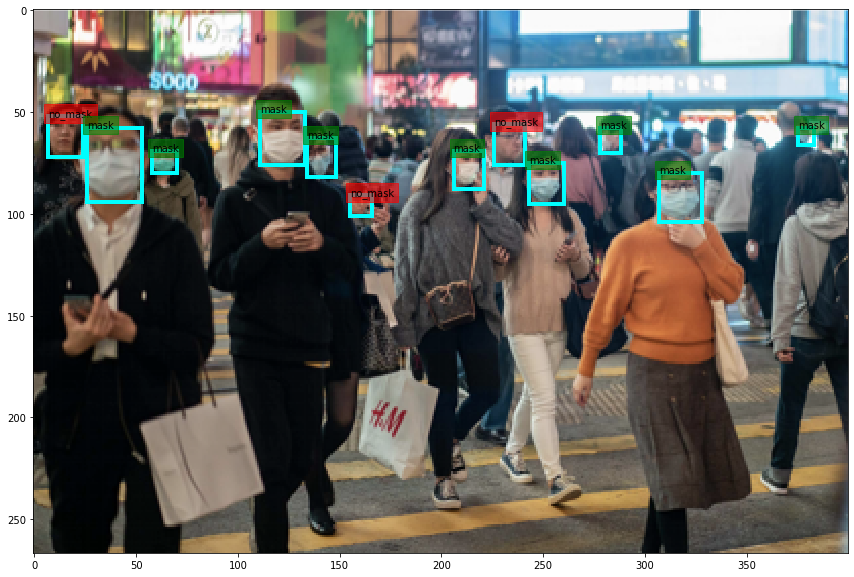

In [14]:
# download the image from S3 bucket
image = info['source-ref'].split('/')[-1]

image_path = 'mask-detection/images/' + image
s3.download_file('solkit-images', image_path, image)

task = "mask-det"
class_map = info[task+'-metadata']['class-map']
image = plt.imread(info['source-ref'].split('/')[-1])
boxes = info[task]['annotations']
colors = ['green','red']

plt.figure(figsize = (20,10))
for box in boxes:
    rec = plt.Rectangle((int(box['left']), int(box['top'])), box['width'], box['height'], fill=None, lw=4, edgecolor='cyan')
    plt.gca().add_patch(rec)
    plt.text(int(box['left']),int(box['top']), CLASSES[box['class_id']], bbox=dict(alpha=0.6, color=colors[box['class_id']]))
plt.imshow(image)
plt.show()

## Train model

### Transfer learning

Here we use a custom Python code to train a model using MXNet(). The MXNet class used for training is derived from the Estimator class.[MXNet SageMaker](https://sagemaker.readthedocs.io/en/stable/frameworks/mxnet/sagemaker.mxnet.html). 

The training script contains the preparation of training data from the manifest file, fine-tuning the SSD-Mobilenet model based on the input hyperparameters. SSD-MobilenetV1 is chosen since MobileNets are lightweight networks with good accuracy and low computation time, hence a good choice for Jetson Nano. Since the dataset is small we use transfer learning for better results. In transfer learning, the network is initialized with weights from a pre-trained model. The base network is trained using [Pascal VOC](http://host.robots.ox.ac.uk/pascal/VOC/). In the fine-tuning session, the last layer is replaced with new classes and the network is trained to obtain better results. The input image size for the model is 512 x 512. Here the hyperparameters epochs and data-shape are only initialized. The other parameters use default values. It can be set according to your training using the argument list in the ssd_entry_mask_detection.py file.

* Deep learning toolkit - [GluonCV](GluonCV)
* Object detection - [SSD](https://arxiv.org/abs/1512.02325)
* MobileNet - [Mobilenet V1](https://arxiv.org/pdf/1704.04861.pdf)
* Introduction to transfer learning - [Transfer learning for Deep Learning](https://machinelearningmastery.com/transfer-learning-for-deep-learning/)



The model was trained using [ml.p3.2xlarge](https://aws.amazon.com/ec2/instance-types/) GPU instance. The EC2 instance price per hour is listed in [EC2 instance pricing](https://aws.amazon.com/ec2/pricing/on-demand/). 30 epochs took approximately 5 hours and cost ~ $22.

You can change the instance using the parameter __train_instance_type__ in the MXNet(). In this example __ml.p3.2xlarge__ instance is used.

The __Estimator__ class in Amazon SageMaker Python SDK is used to set the training parameters and fit the model. [Estimator SageMaker Python SDK](https://sagemaker.readthedocs.io/en/stable/api/training/estimators.html)



In [15]:
#Assign the output location with S3 output directory
prefix = 'mask-detection-example'
s3_output_location = 's3://{}/{}/output'.format(bucket, prefix)

# location to store custom mode
custom_code_upload_location = 's3://{}/{}/custom_code'.format(bucket, prefix)

#set hyperparameters and train model
mxnet_estimator = MXNet(entry_point='ssd_entry_mask_detection.py',
                      output_path=s3_output_location,
                      code_location=custom_code_upload_location,
                      role=role,
                      train_instance_count=1,
                      train_instance_type='ml.p3.2xlarge',
                      framework_version='1.6.0',
                      py_version='py3',
                      hyperparameters={'epochs': 80,
                                       'data-shape': 512,
                                       'lr' : 0.001,
                                       'lr-decay' : 0.1,
                                       'batch-size' : 16
                                      }
                     )

In [16]:
# Checking the training and label data folder
s3_train_data = 's3://{}/{}'.format(bucket,train_data_prefix)
s3_label_data = 's3://{}/{}'.format(bucket,label_data_prefix)

print(s3_train_data)
print(s3_label_data)

s3://evs-smk/mask-detection-example/images
s3://evs-smk/mask-detection-example/labels


### Fit model
The estimator class contains fit() which calls the train() in the entry point. We can see the logs in the output. If more information is required, we have to set it in the python code. 

__Note__: Get the current status and monitor your training job from __Amazon SageMaker -> Training Jobs -> _your training job___. The training job cannot be stopped from the notebook. If required, stop the training from Training Jobs.
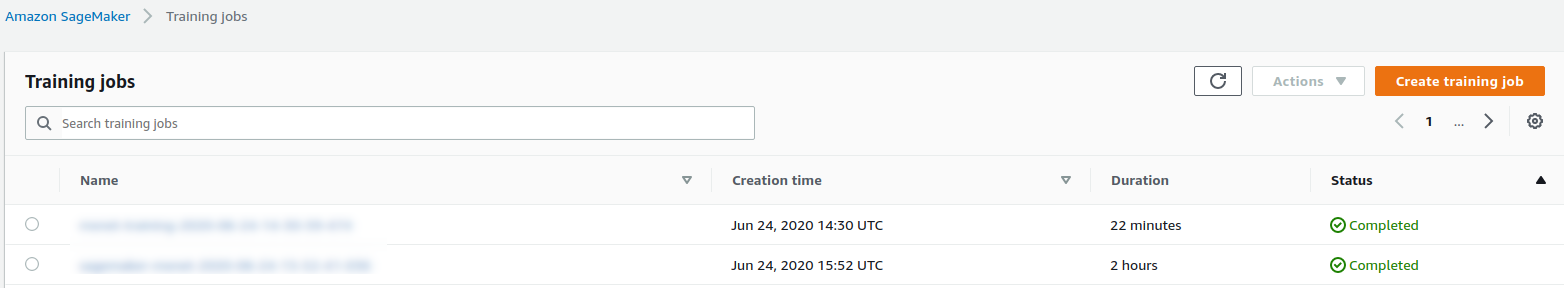

___Give a unique job name for the training. Job name should be unique similar to notebook instance name. The characters should be ^[a-zA-Z0-9](-*[a-zA-Z0-9])*___. This example always generates a unique name.

In [17]:
from sagemaker.utils import name_from_base

s3_train_data = 's3://{}/{}'.format(bucket,train_data_prefix)
s3_label_data = 's3://{}/{}'.format(bucket,label_data_prefix)

job_name = name_from_base('mask-detector-example')

mxnet_estimator.fit({'train': s3_train_data, 'labels': s3_label_data},job_name = job_name)

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


2020-08-10 09:29:28 Starting - Starting the training job...
2020-08-10 09:29:30 Starting - Launching requested ML instances......
2020-08-10 09:30:35 Starting - Preparing the instances for training......
2020-08-10 09:31:54 Downloading - Downloading input data
2020-08-10 09:31:54 Training - Downloading the training image...
2020-08-10 09:32:18 Training - Training image download completed. Training in progress.2020-08-10 09:32:18,714 sagemaker-containers INFO     Imported framework sagemaker_mxnet_container.training
2020-08-10 09:32:18,740 sagemaker_mxnet_container.training INFO     MXNet training environment: {'SM_HOSTS': '["algo-1"]', 'SM_NETWORK_INTERFACE_NAME': 'eth0', 'SM_HPS': '{"batch-size":8,"data-shape":512,"epochs":1,"lr":0.001,"lr-decay":0.1}', 'SM_USER_ENTRY_POINT': 'ssd_entry_mask_detection.py', 'SM_FRAMEWORK_PARAMS': '{}', 'SM_RESOURCE_CONFIG': '{"current_host":"algo-1","hosts":["algo-1"],"network_interface_name":"eth0"}', 'SM_INPUT_DATA_CONFIG': '{"labels":{"RecordWrapper

## Predictions by trained model on notebook instance(optional)

The test results on the trained model. Here the trained models are not deployed on a cloud instance. The models are downloaded from the S3 bucket to the notebook instance and results are predicted using a custom python code. Images are from [Google_advanced_image_search](https://www.google.com/advanced_image_search).

In [18]:
# Download model from S3 to the current directory
output_path_prefix = '{}/output/{}/output/model.tar.gz'.format(prefix,job_name)
path =sagemaker_session.download_data('./',bucket, key_prefix=output_path_prefix)

In [19]:
# import the gluoncv modules for prediction
from gluoncv.utils import viz
from mxnet import gluon
from mxnet import nd

In [20]:
!tar -xvf model.tar.gz 
!rm model.tar.gz

model-symbol.json
model-0000.params


In [ ]:
# Load model
net =gluon.SymbolBlock.imports('model-symbol.json',['data'],'model-0000.params')
net.hybridize(static_alloc=True, static_shape=True)
net(mx.nd.ones((1,3,512,512)))

### Images for prediction
The images for prediction should be uploaded to the notebook instance. Here two images are used. The images are obtained from [Google_advanced_image_search](https://www.google.com/advanced_image_search). One from each class. Enter the image names to be tested. Assign the list of images to __image_files__. 

__Note:__ This result images where obtained by the completely trained model.

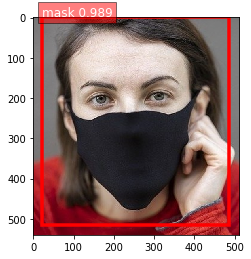

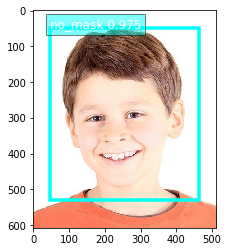

In [24]:
# predict the results
classes = ['mask','no_mask']
#image_files = ['< test-image-1 >','<test-images-2 >']
image_files = ['mask.jpg','no_mask.jpg']

for i in image_files:
    x, image = gcv.data.transforms.presets.ssd.load_test(i, 512)
    cid, score, bbox = net(x)

    ax = viz.plot_bbox(image, bbox[0], score[0], cid[0], class_names=classes,thresh=0.5)
    plt.show()

## Compile model

Compile the model for optimal inference on Jetson Nano. The function __compile_model()__ is used for model compilation. The SageMaker neo compiles the model in S3 output location such that the optimal model is obtained for the target device __Jetson Nano__.

For more information, please have a look at the following websites.

[SageMaker Neo](https://docs.aws.amazon.com/sagemaker/latest/dg/neo.html)


[Neo Troubleshooting](https://docs.aws.amazon.com/sagemaker/latest/dg/neo-troubleshooting.html)

In [25]:
target_device = 'jetson_nano'
input_data = {'data':[1, 3, 512, 512]}
compiled_model = mxnet_estimator.compile_model(target_instance_family=target_device,
                                             input_shape=input_data,
                                             output_path=s3_output_location,
                                             framework='mxnet', 
                                             framework_version='1.6.0'
                                            )


Parameter image will be renamed to image_uri in SageMaker Python SDK v2.
'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


?......!

The instance type jetson_nano is not supported to deploy via SageMaker,please deploy the model manually.


### Download model to the notebook instance

Download the compiled model from S3 path to working directory in the notebook instance. 

In [26]:
compiled_model_name = '{}-{}.tar.gz'.format('model', target_device)
output = '{}/output/{}'.format(prefix,compiled_model_name)
sagemaker_session.download_data('./',bucket,key_prefix=output)

### Add class list to the compiled model and upload it to the desired S3 bucket

In [27]:
!mkdir compiled_model
!mv classes.lst compiled_model/

In [30]:
command = 'tar xvf '+compiled_model_name+' -C compiled_model'
os.system(command)

0

In [31]:
new_model_name = 'mask-detection-model.tar.gz'
command = 'tar -C compiled_model -czvf ' + new_model_name + ' .'
os.system(command)

0

In [32]:
!rm -r compiled_model/

In [34]:
# upload model to the destination bucket
prefix = 'jetson_nano_models'
model_path = sagemaker_session.upload_data(path=new_model_name, key_prefix= prefix)

# prints the path to the final model
print('S3 file path ' +model_path)


S3 file path s3://evs-smk/jetson_nano_models/mask-detection-model.tar.gz


## Run inference on Jetson Nano

Finally deploy the model on Jetson Nano.